In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys
import pandas as pd
import os
sys.path.append("../")
import utils.common
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from utils.common import get_trial_paths, get_trial_df, get_initial_state_df, get_prey_pos_df, display_prey_agent_pos, get_agent_pos_df, get_occluders_pos_df

logger = logging.getLogger()
logger.setLevel(logging.ERROR)
logger.info('DEBUG')

In [3]:
human_base_path = '../../logs/exp_pong_single_ball/1'
trial_paths = get_trial_paths(human_base_path)
trial_df = get_trial_df(trial_paths)
trial_df = (trial_df.pipe(get_initial_state_df)
    .pipe(utils.common.get_condition_df)
    .drop('initial_state', axis='columns')    
    .pipe(get_prey_pos_df)
    .pipe(get_agent_pos_df)
    .pipe(get_occluders_pos_df)    
    .assign(trial_end_step=utils.common.get_trial_end_step)
    .pipe(utils.common.trim_pos, 'agent_pos')
    .pipe(utils.common.trim_pos, 'prey_pos')
    .pipe(utils.common.trim_pos, 'occluders_pos')    
    .assign(success=utils.common.get_success,)
    .assign(        
        agent_vel=utils.common.get_agent_vel,
        prey_visible=utils.common.get_prey_visible,     
        prey_visible_step=utils.common.get_prey_visible_step, 
        error=utils.common.get_error)        
    .set_index(['prey_x', 'occluded'])
    .sort_index()
)


In [34]:
n_conditions = 3
conditions = np.random.choice(trial_df.loc[pd.IndexSlice[:, True], :].index.unique(), n_conditions, replace=False)
f, axs = plt.subplots(1, n_conditions, figsize=(15, 5), dpi=100, sharey=True)
for i_c, condition in enumerate(conditions):
    trials = trial_df.loc[condition].sample(20, replace=False)
    agent_pos = trials.agent_pos.to_numpy()
    trial_end_step = trials.trial_end_step.to_numpy()
    success = trials.success.to_numpy()
    prey_pos = trials.prey_pos.to_numpy()
    visibility_step = trials.prey_visible_step.to_numpy()
    n_trials = len(trials)
    
    for i, (ap, vs, s, pp) in enumerate(list(zip(agent_pos, visibility_step, success, prey_pos))):
        ap = np.asarray(ap).squeeze()[:, 0]
        pp = np.asarray(pp).squeeze()[:, 0]
        vap = ap[vs:] if vs != -1 else []
        oap = ap[:vs]
        ot = np.arange(vs) if vs != -1 else np.arange(len(ap)-1)        
        vt = np.arange(start=vs, stop=len(ap), step=1) if vs != -1 else []        
        linestyle = '-' if s else '--'                
        color = 'b' if s else 'r'
        axs[i_c].plot(ot, oap, color='r', linestyle=linestyle, alpha=0.2)    
        axs[i_c].plot(vt, vap, color='b', linestyle=linestyle, alpha=0.2)
        # axs[i_c].plot(np.arange(len(ap)), ap, linestyle='--', alpha=0.3, color='k')
        axs[i_c].set_xlabel('timestep')
    axs[0].set_ylabel('x-coordinate')        
    pp = prey_pos[-1].squeeze()
    t_start = np.where(pp[:, 1] <= 1.0)[0][0]
    t_end = np.where(pp[:, 1] <= 0.2)[0][0]
    t = np.arange(t_start, t_end)
    axs[i_c].scatter(t, pp[t_start:t_end, 0], c=np.flip(pp[t_start:t_end, 1]), cmap='viridis', marker='o', s=40, alpha=1)     
    # axs[i_c].plot(np.arange(len(ap)), pp,  alpha=0.7, color='g')    
plt.tight_layout()
plt.show()

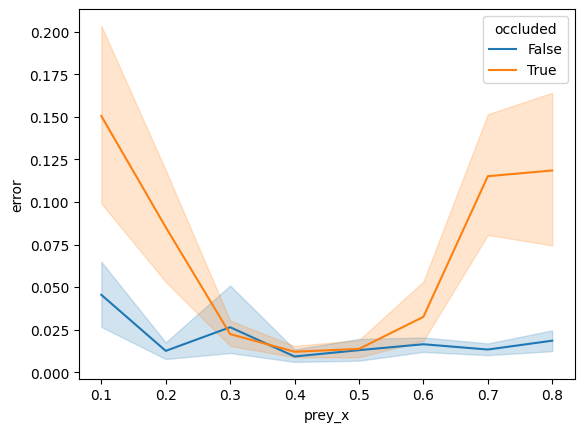

In [11]:

sns.lineplot(x='prey_x', y='error', hue='occluded', data=trial_df.reset_index())
plt.show()

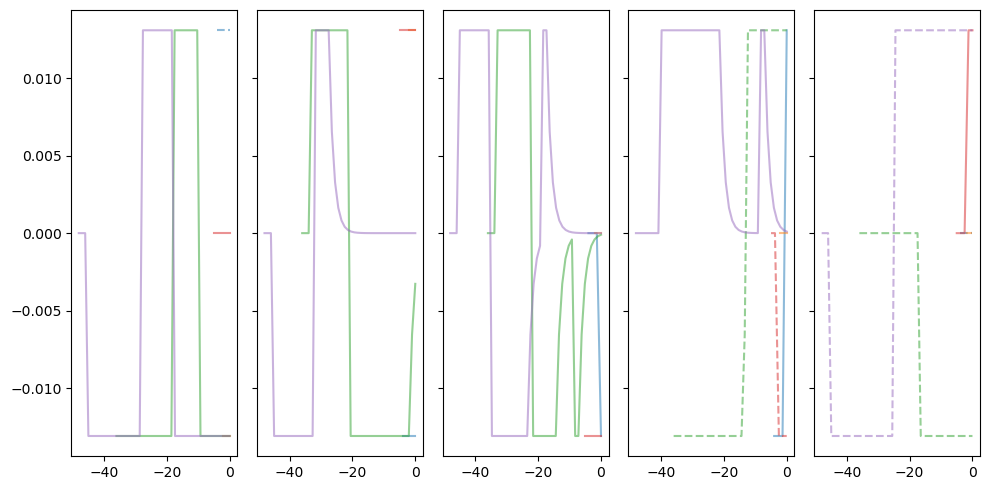

In [72]:
n_conditions = 5
conditions = np.random.choice(trial_df.loc[pd.IndexSlice[:, True], :].index.unique(), n_conditions, replace=False)
f, axs = plt.subplots(1, n_conditions, figsize=(10, 5), dpi=100, sharey=True)
for i_c, condition in enumerate(conditions):
    trials = trial_df.loc[condition].sample(5, replace=False)
    agent_vel = trials.agent_vel.to_numpy()
    success = trials.success.to_numpy()
    for i, (av, vs, s) in enumerate(list(zip(agent_vel, visibility_step, success))):
        if vs != -1:
            av = av[:vs]                
            avt = np.linspace(-vs, 0, num=vs)
            linestyle = '-' if s else '--'                            
            axs[i_c].plot(avt, av, linestyle=linestyle, alpha=0.5)                                         
plt.tight_layout()
plt.show()